# Developing Dashboards Using Jupyter Widgets
*Using Jupyter Widgets, Pandas Dataframes and Matplotlib*

While BPTK-Py offers a number of high-level functions to quickly plot equations (such as `bptk.plot_scenarios`) or create a dashboard (e.g. the `SimpleDashboard` utility class), it is sometimes necessary to create more sophisticated plots (e.g. plots with two axes) or a more sophisticated interface dashboard for your simulation. 

This is actually quite easy, because BPTK-Py's high-level functions utilize some very powerful open source libraries for data management, plotting, and dashboards: Pandas, Matplotlib, and Jupyter Widgets.

In order to harness the full power of these libraries, it is only necessary to understand how to make the data generated by BPTK-Py available to them. This _How To_ illustrates this using a neat little simulation of customer acquisition strategies. It is not required to understand the simulation to follow this document, but if you are interested you can read more about it on our [blog](https://www.transentis.com/an-example-to-illustrate-the-business-prototyping-methodology/). 

## Advanced Plotting

We'll start with some advanced plotting of simulation results.

In [1]:
## Load the BPTK Package
from BPTK_Py.bptk import bptk

bptk = bptk()

In [2]:
#| echo: false
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

BPTK-Py's workhorse for creating plots is the `bptk.plot_scenarios` function. The function generates the data you want to plot using the simulation defined by the scenario manager and the settings defined by the scenarios. The data are stored in a Pandas dataframe. For plotting results, the framework uses Matplotlib. To illustrate this, we will recreate the plot below manually:

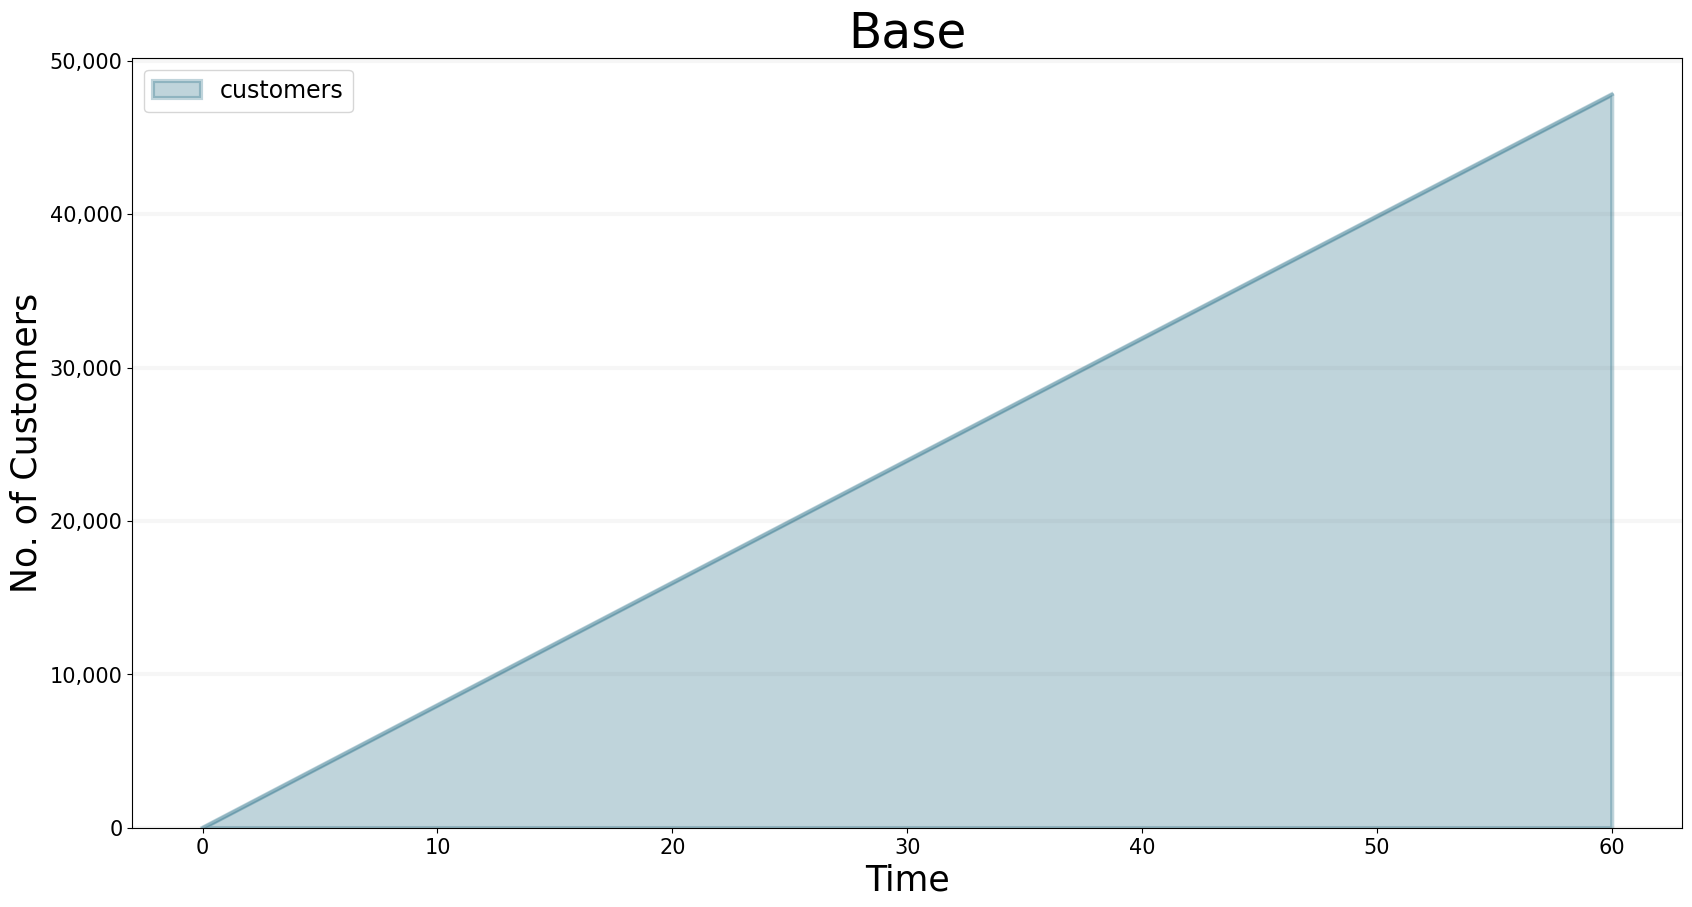

In [3]:
bptk.plot_scenarios(
    scenario_managers=["smCustomerAcquisition"],
    scenarios=["base"], 
    equations=['customers'],
    title="Base",
    freq="M",
    x_label="Time",
    y_label="No. of Customers"
)

The data generated by a scenario is can be saved into a dataframe. This can be achieved by adding the `return_df` flag to `bptk.plot_scenario`:

In [4]:
df=bptk.plot_scenarios(
    scenario_managers=["smCustomerAcquisition"],
    scenarios=["base"], 
    equations=['customers'],
    title="Base",
    freq="M",
    x_label="Time",
    y_label="No. of Customers",
    return_df=True
)

The dataframe is indexed by timestep and stores the equations (in SD models) or agent properties (in Agent-based models) in the columns.

In [5]:
df[0:10] # just show the first ten items

,customers
t,
0.0,0.000000
1.0,800.000000
2.0,1599.893333
3.0,2399.680014
4.0,3199.360057
5.0,3998.933476
6.0,4798.400284
7.0,5597.760498
8.0,6397.014130


Internally, the `bptk.plot_scenarios` method first runs the simulation using the settings defined in the scenario and stores the data in a dataframe. It then plots the dataframe using Pandas `df.plot`method.

We can do the same:

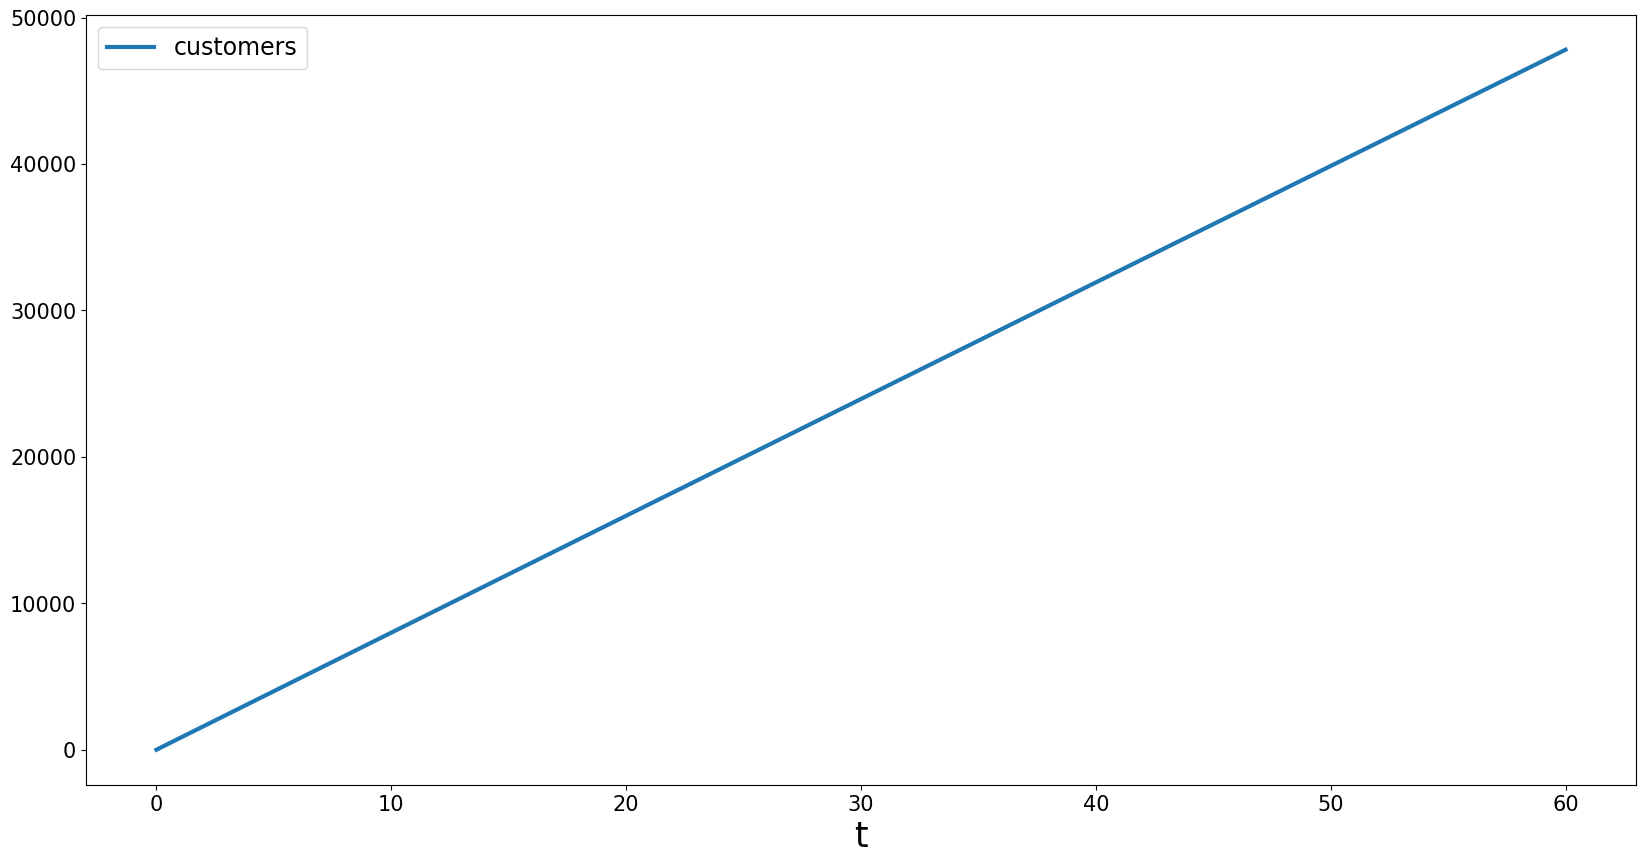

In [6]:
subplot=df.plot(None,"customers")

Because we are missing some styling information, the plot above doesn't look quite as neat as the plots created by `bptk.plot_scenarios`. The styling information is stored in BPTK_Py.config, and you can access (and modify) it there.

Now let's apply the config to `df.plot`:

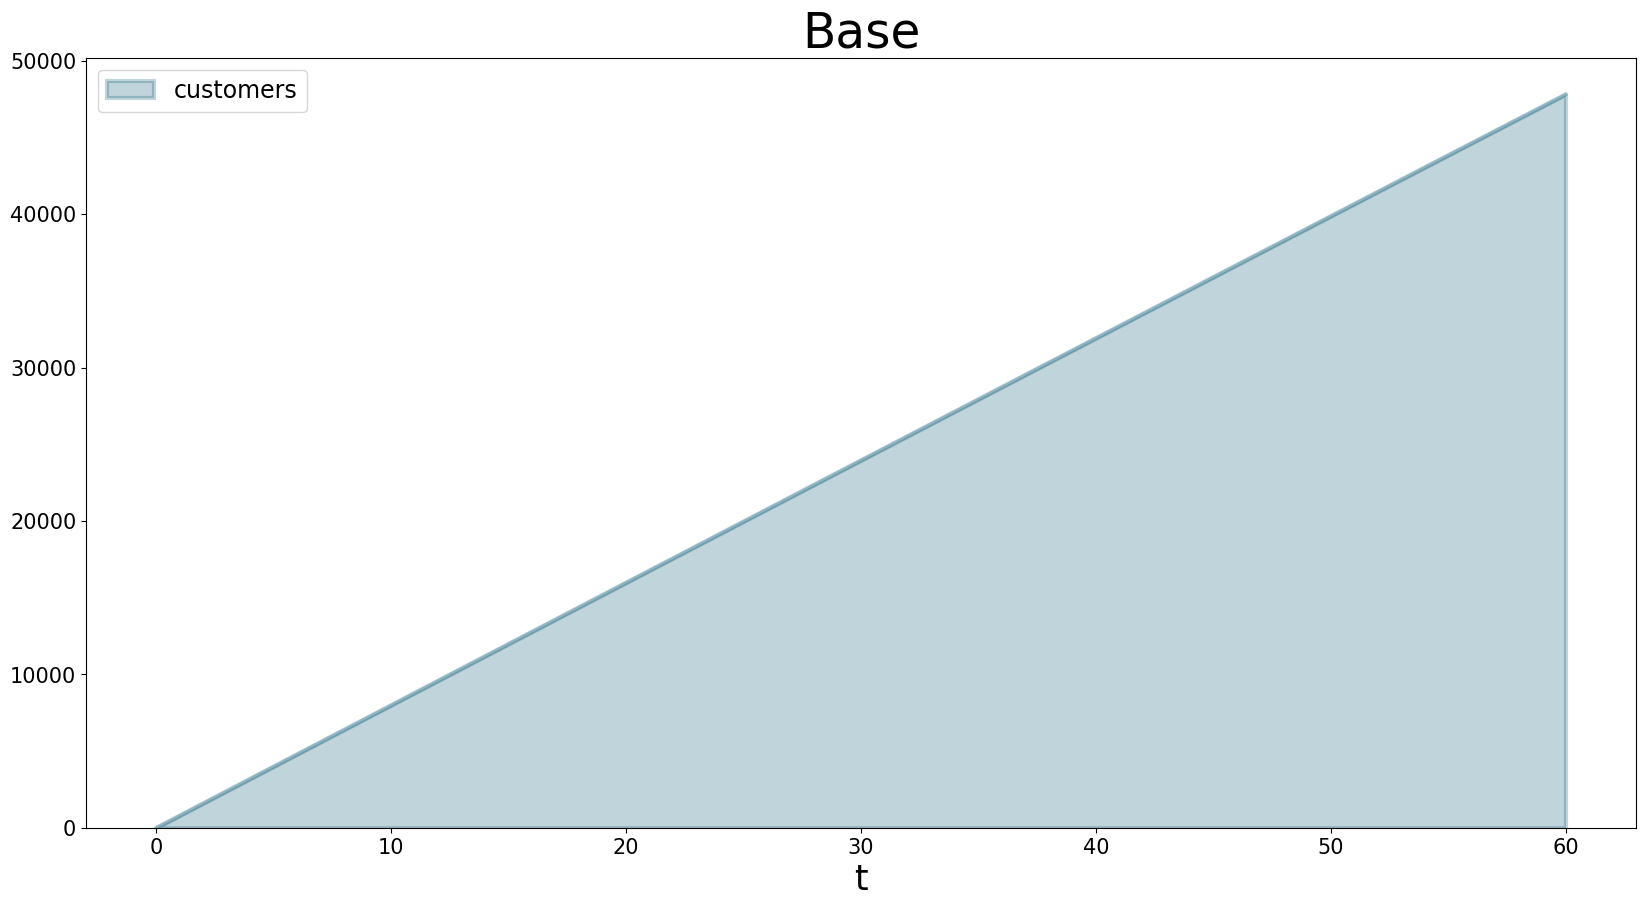

In [7]:
import BPTK_Py.config as config

subplot=df.plot(
    kind=config.configuration["kind"],
    alpha=config.configuration["alpha"], 
    stacked=config.configuration["stacked"],
    figsize=config.configuration["figsize"],
    title="Base",
    color=config.configuration["colors"],
    lw=config.configuration["linewidth"]
)

Yes! We've recreated the plot from the high level `btpk.plot_scenarios` method using basic plotting functions.

Now let's do something that is currently not possible using the high-level BPTK-Py methods - let's create a graph that has two y-axes.

This is useful when you want to show the results of two equations at the same time, but they need to have different scales on the y-axis. For instance, in the plot below, the number of customers is much smaller than the profit made, so the customer graph looks like a straight line.

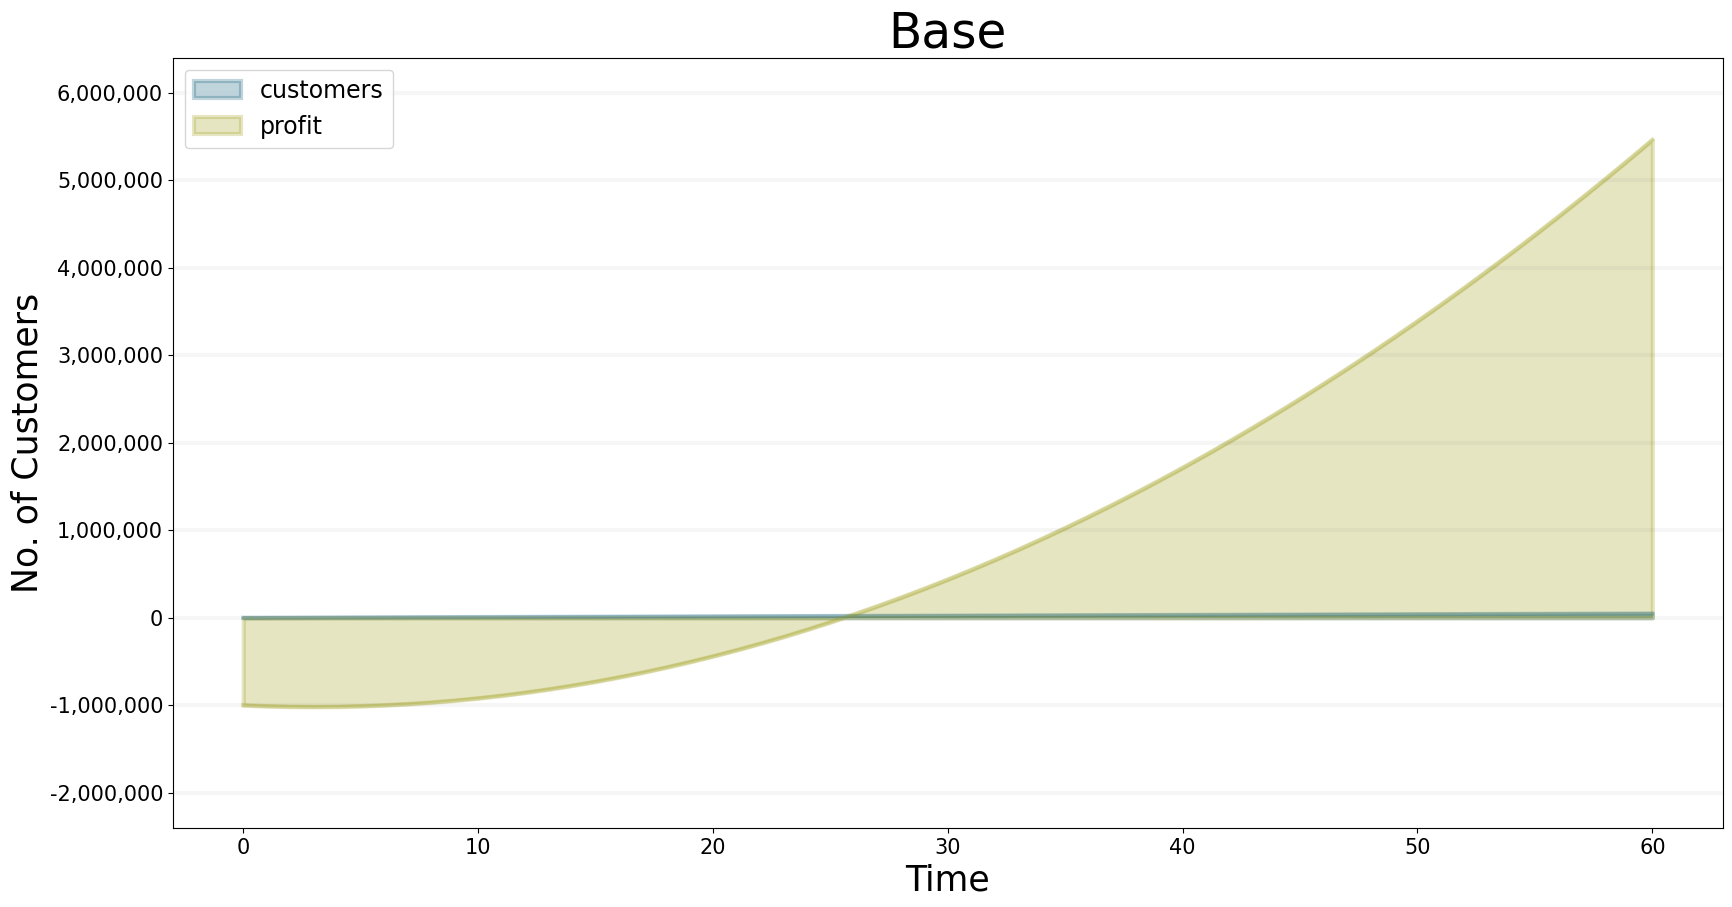

In [8]:
bptk.plot_scenarios(
    scenario_managers=["smCustomerAcquisition"],
    scenarios=["base"], 
    equations=['customers','profit'],
    title="Base",
    freq="M",
    x_label="Time",
    y_label="No. of Customers"
)

As before, we collect the data in a dataframe.

In [9]:
df=bptk.plot_scenarios(
    scenario_managers=["smCustomerAcquisition"],
    scenarios=["base"], 
    equations=['customers','profit'],
    title="Base",
    freq="M",
    x_label="Time",
    y_label="No. of Customers",
    return_df = True
)

In [10]:
df[0:10]

,customers,profit
t,,
0.0,0.000000,-1.000000e+06
1.0,800.000000,-1.010000e+06
2.0,1599.893333,-1.016000e+06
3.0,2399.680014,-1.018001e+06
4.0,3199.360057,-1.016002e+06
5.0,3998.933476,-1.010005e+06
6.0,4798.400284,-1.000011e+06
7.0,5597.760498,-9.860187e+05
8.0,6397.014130,-9.680299e+05


Plotting two axes is easy in Pandas (which itself uses the Matplotlib library):

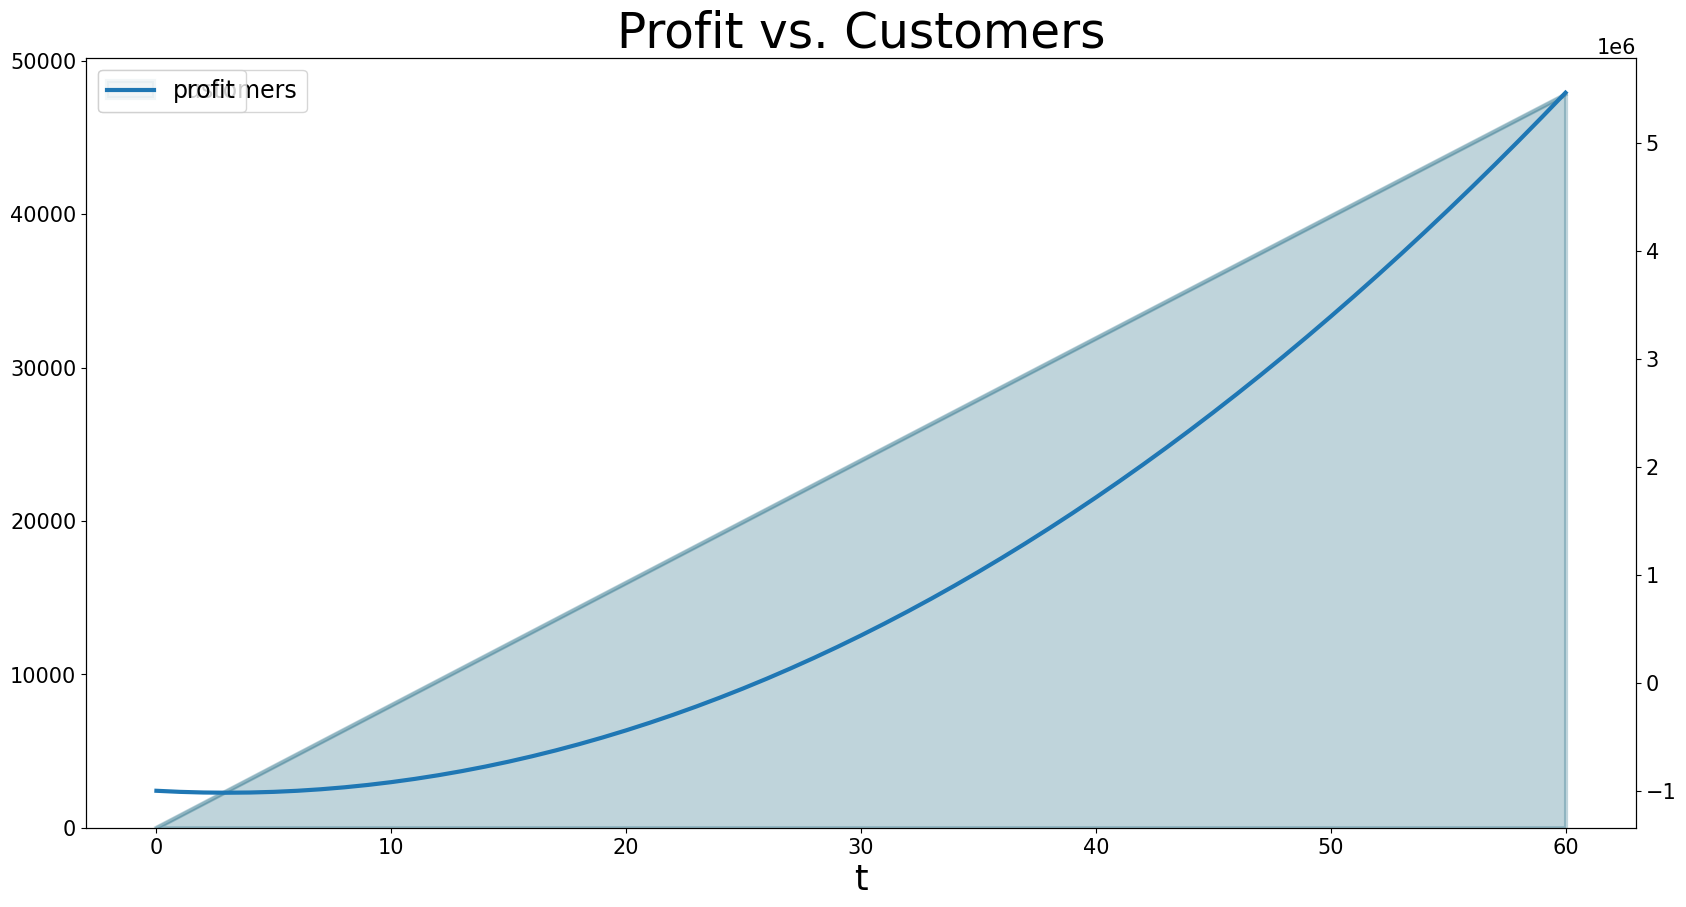

In [11]:
ax = df.plot(
    None,'customers', 
    kind=config.configuration["kind"],
    alpha=config.configuration["alpha"], 
    stacked=config.configuration["stacked"],
    figsize=config.configuration["figsize"],
    title="Profit vs. Customers",
    color=config.configuration["colors"],
    lw=config.configuration["linewidth"]
)
# ax is a Matplotlib Axes object

ax1 = ax.twinx()

# Matplotlib.axes.Axes.twinx creates a twin y-axis.

plot =df.plot(None,'profit',ax=ax1)

Voilà! 

Once you have the data from BPTK you can do anything Pandas and Matplotlib allow you to do. It might be helpful to get a deeper look at how these libraries work when creating more complex dashboards and plots.

## Advanced interactive user interfaces
Now let's try something a little more challenging: Let's build a dashboard for our simulation that let's you manipulate some of the scenrio settings interactively and plots results in tabs.

> Note: You need to have widgets enabled in Jupyter for the following to work. Please check the [BPTK-Py installation instructions](https://bptk.transentis-labs.com/en/latest/docs/usage/installation.html) or refer to the [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/user_install.html) documentation 

First, we need to understand how to create tabs. For this we need to import the `ipywidget` Library and we also need to access Matplotlib's `pyplot`

In [12]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [13]:
#| echo: false
plt.style.use('default')

Then we can create some tabs that display scenario results as follows:

In [14]:
out1 = widgets.Output()
out2 = widgets.Output()

tabs = widgets.Tab(children = [out1, out2])
tabs.set_title(0, 'Customers')
tabs.set_title(1, 'Profit')

display(tabs)

with out1:
    # turn of pyplot's interactive mode to ensure the plot is not created directly
    plt.ioff() 
    # create the plot, but don't show it yet
    bptk.plot_scenarios(
        scenario_managers=["smCustomerAcquisition"],
        scenarios=["hereWeGo"], 
        equations=['customers'],
        title="Customers",
        freq="M",
        x_label="Time",
        y_label="No. of Customers"
    )
    # show the plot
    plt.show()
    # turn interactive mode on again
    plt.ion()

with out2:
    plt.ioff()
    bptk.plot_scenarios(
        scenario_managers=["smCustomerAcquisition"],
        scenarios=["hereWeGo"], 
        equations=['profit'],
        title="Profit",
        freq="M",
        x_label="Time",
        y_label="Euro"
    )
    plt.show()
    plt.ion()

That was easy! The only thing you really need to understand is to turn interactive plotting in `pyplot` off before creating the tabs and then turn it on again to create the plots. If you forget to do that, the plots appear above the tabs (try it and see!). 

In the next step, we need to add some sliders to manipulate the following scenario settings:

* Referrals
* Referral Free Months
* Referral Program Adoption %
* Advertising Success %

Creating a slider for the referrals is easy using the integer slider from the `ipywidgets` widget library:

In [15]:
widgets.IntSlider(
    value=7,
    min=0,
    max=15,
    step=1,
    description='Referrals:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

IntSlider(value=7, continuous_update=False, description='Referrals:', max=15)

When manipulating a simulation model, we mostly want to start with a particular scenario and then manipulate some of the scenario settings using interactive widgets. Let's set up a new scenario for this purpose and call it `interactiveScenario`:

In [16]:
bptk.register_scenarios(
    scenario_manager="smCustomerAcquisition", 
    scenarios= {
        "interactiveScenario": {
            "constants": {
                "referrals":0,
                "advertisingSuccessPct":0.1,
                "referralFreeMonths":3,
                "referralProgamAdoptionPct":10
            }
        }
    }
)

We can then access the scenario using `bptk.get_scenarios`: 

In [17]:
scenario = bptk.get_scenario("smCustomerAcquisition","interactiveScenario")
scenario.constants

{'referrals': 0,
 'advertisingSuccessPct': 0.1,
 'referralFreeMonths': 3,
 'referralProgamAdoptionPct': 10,
 'initialCustomers': 0,
 'targetCustomerDilutionPct': 80,
 'personsReachedPerEuro': 100,
 'classicAdvertisingCost': 10000,
 'targetMarket': 6000000,
 'initialInvestmentInServive': 1000000,
 'serviceMargin': 0.5,
 'serviceFee': 10,
 'referralAdvertisingCost': 10000,
 'referralProgramAdoptionPct': 10}

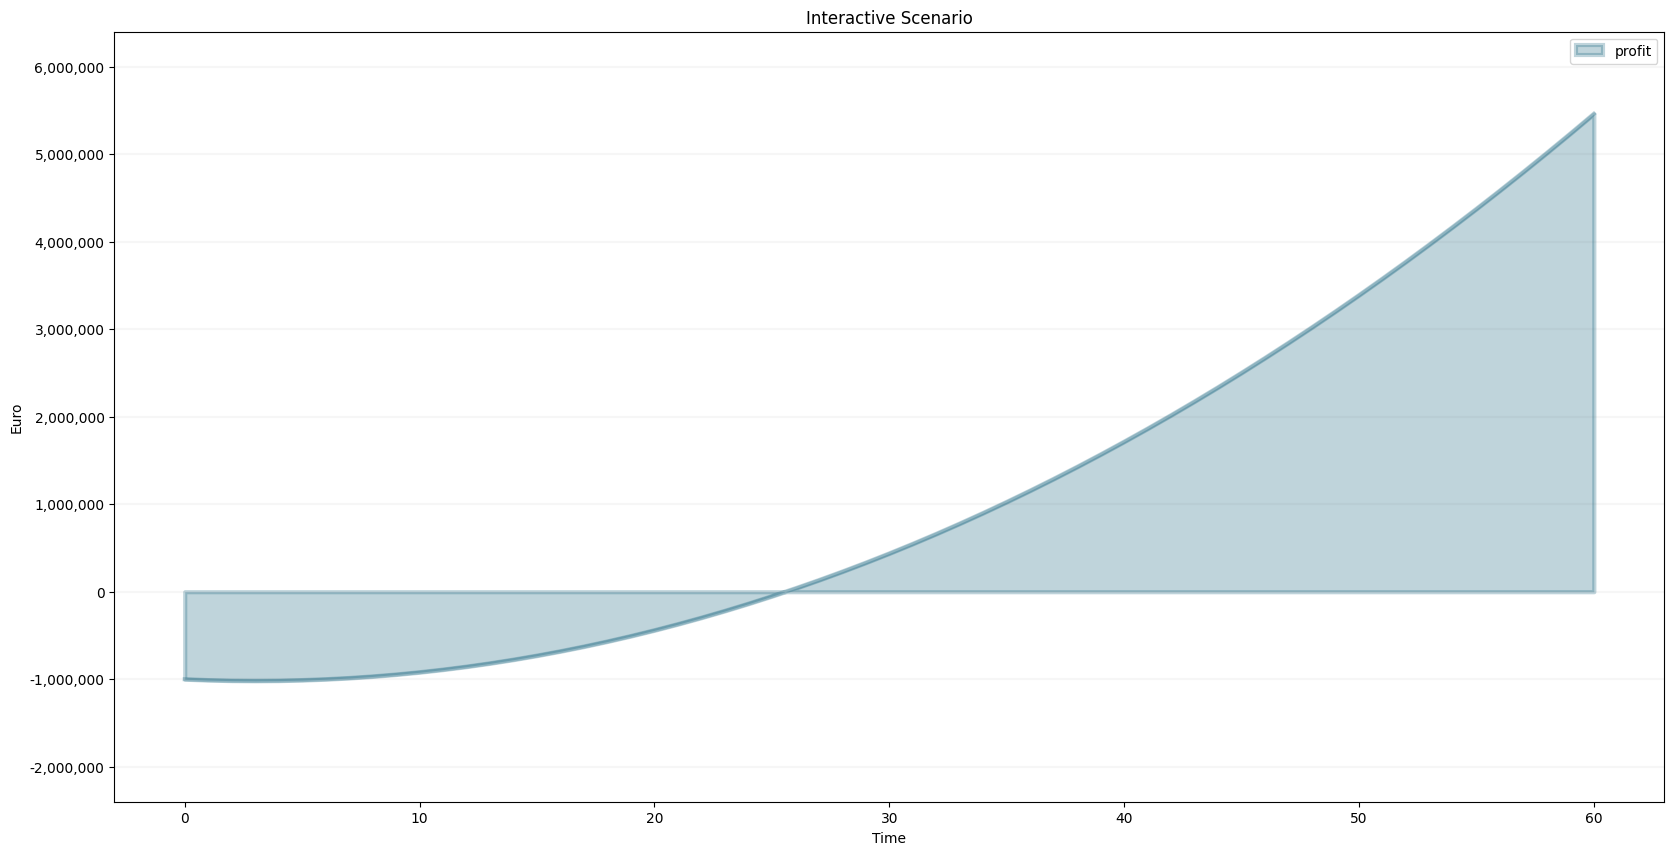

In [18]:
bptk.plot_scenarios(scenario_managers=["smCustomerAcquisition"],
    scenarios=["interactiveScenario"], 
    equations=['profit'],
    title="Interactive Scenario",
    freq="M",
    x_label="Time",
    y_label="Euro"
)

The scenario constants can be accessed in the constants variable:

Now we have all the right pieces, we can put them together using the interact function.

In [19]:
@interact(referrals=widgets.FloatSlider(
    value=1,
    min=0,
    max=15,
    step=1,
    continuous_update=False,
    description='Advertising Success Pct',
    # Note: Remove locally to enable the slider
    disabled=True,
))
def dashboard(referrals):
    scenario= bptk.get_scenario("smCustomerAcquisition", "interactiveScenario")
    
    scenario.constants["referrals"]=referrals
    bptk.reset_scenario_cache(scenario_manager="smCustomerAcquisition", scenario="interactiveScenario")
    bptk.plot_scenarios(
        scenario_managers=["smCustomerAcquisition"],
        scenarios=["interactiveScenario"], 
        equations=['profit'],
        title="Interactive Scenario",
        freq="M",
        x_label="Time",
        y_label="Euro"
    )

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Advertising Success Pct', d…

Now let's combine this with the tabs from above.

In [20]:
out1 = widgets.Output()
out2 = widgets.Output()


tab = widgets.Tab(children = [out1, out2])
tab.set_title(0, 'Customers')
tab.set_title(1, 'Profit')
display(tab)
    
@interact(referrals=widgets.FloatSlider(
    value=0,
    min=0,
    max=15,
    step=1,
    continuous_update=False,
    description='Advertising Success Pct',
    # Note: Remove locally to enable the slider
    disabled=True,
))
def dashboardWithTabs(referrals):
    scenario= bptk.get_scenario("smCustomerAcquisition","interactiveScenario")
    
    scenario.constants["referrals"]=referrals
    bptk.reset_scenario_cache(scenario_manager="smCustomerAcquisition", scenario="interactiveScenario")
   
   
     
    with out1:
        # turn of pyplot's interactive mode to ensure the plot is not created directly
        plt.ioff() 
        # clear the widgets output ... otherwise we will end up with a long list of plots, one for each change of settings
        
        # create the plot, but don't show it yet
        bptk.plot_scenarios(
            scenario_managers=["smCustomerAcquisition"],
            scenarios=["interactiveScenario"], 
            equations=['customers'],
            title="Customers",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
        )
        # show the plot
        out1.clear_output() 
        plt.show()
        # turn interactive mode on again
        plt.ion()

    with out2:
        plt.ioff()
        out2.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["smCustomerAcquisition"],
            scenarios=["interactiveScenario"], 
            equations=['profit'],
            title="Profit",
            freq="M",
            x_label="Time",
            y_label="Euro"
        )
        plt.show()
        plt.ion()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Advertising Success Pct', d…